In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
from torchwi import Time2d
from torchwi.io import rsf, TimeDataset
from torchwi.parameter import VelocityParameter

In [3]:
fwav="../data_marm/wavelet.rsf"
fshot="../data_marm/shot.rsf"
fvel="../data_marm/vinit.rsf"

nt,dt,w = rsf.fromfile(fwav,"n1 d1 data")
ny,nx,h,vinit = rsf.fromfile(fvel,"n1 n2 d1 data")
nshot,sxy = rsf.fromfile(fshot,"n2 data")

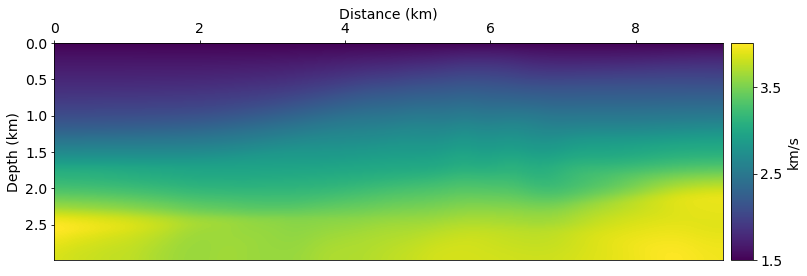

In [4]:
from torchwi.utils.plot import plot_vel
plot_vel(vinit,h)

In [5]:
DEVICE='cuda'
vmin=1.5
vmax=5.5
order=2

vp = VelocityParameter(torch.from_numpy(vinit).to(DEVICE),vmin,vmax)
model = Time2d(nx,ny,h,torch.from_numpy(w),dt,order,DEVICE).to(DEVICE).train()

In [6]:
from torchwi.io import MainLogger
logger=MainLogger()
print("log dir = %s"%logger.get_logdir())

log dir = runs/Nov04_02-10-58_gpu-server


In [7]:
LR=0.05
optimizer= torch.optim.Adam(vp.parameters(), lr=LR)

In [8]:
ftrue="../forward/seismo."
dataloader = torch.utils.data.DataLoader(TimeDataset(torch.from_numpy(sxy),ftrue))

In [9]:
num_epochs = 301

for epoch in range(num_epochs):
    total_loss = 0.
    optimizer.zero_grad()
    
    for sx,sy,true in dataloader: # batch size=1 to save memory
        true = true.to(DEVICE)
        ry=sy
        frd = model(vp(),sx,sy,ry)
        loss = 0.5*torch.sum((frd-true.view_as(frd))**2)
        loss.backward() # accumulate gradient
        
        total_loss += loss.item()

    # all shot gradient
    optimizer.step()
    
    if epoch == 0:
        loss0 = total_loss
    logger.progress_bar(epoch,num_epochs,"norm loss=%9.3e"%(total_loss/loss0))
    logger.log_loss(total_loss, epoch)
    if epoch % 10 == 0:
        logger.log_velocity(vp(),epoch,h,vmin,vmax)

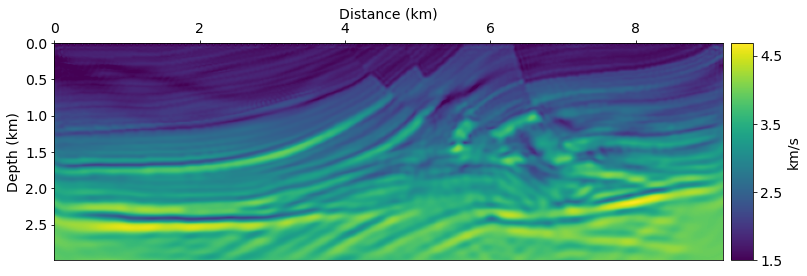

In [10]:
plot_vel(vp().to('cpu').detach().numpy(),h)